In [208]:
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc

import pandas as pd
import os
import seaborn as sns
from skbio.diversity import alpha_diversity
from skbio.diversity import beta_diversity
from skbio import TreeNode
from io import StringIO

In [73]:
from imports import *


def get_data_for_sample(path_to_file):
    dataset = path_to_file.split('/')[-1]
    df = pd.read_csv(path_to_file, delimiter = ',')
    df['Dataset'] = dataset
    df["Name"] = [n.strip() for n in df["Name"]]
    return df

def get_table_and_grouping(df_name, table_files, column_to_group='STUDY_CONDITION', rank='F', 
                           use_percent= True, percent=30, group=None, group_to_drop = None, counts=True):

    for file in table_files:
        if df_name in file:
            index = table_files.index(file)
            
    df = get_data_for_sample(table_files[index])
    df_2 = df.loc[df['Rank'] == rank]
    
    if len(df_2) == 0:
        raise WrongRank(rank)
    
    df_2 = df_2[['Sample_ID', 'Name', 'Abundance', column_to_group]]
    df_2 = df_2.loc[[i == i for i in df_2[column_to_group]]]

    if group is not None:
        df_2[column_to_group] = [group if group in v else "Control" for v in df_2[column_to_group]]

    if group_to_drop is not None:
        df_2 = df_2.loc[df_2[column_to_group] != group_to_drop]
                       
    table = df_2.pivot(index='Sample_ID', columns='Name', values='Abundance')
        
    # Handling remaining Nan values
    table_repl = table.fillna(0)

    # Switching from abundance to counts
    if counts:
        columns = table_repl.columns
        def calc_count(row):
            min_val = max(row)
            for col in columns:
                if row[col] > 0 and row[col] < min_val:
                    min_val = row[col]
                    
            to_mult = 1 / min_val
            for col in columns:
                if row[col] > 0:
                    row[col] = round(row[col]*to_mult)
            return row

        table_repl = table_repl.apply(calc_count,axis=1)

    grouping = df_2[['Sample_ID', column_to_group]].drop_duplicates()
    grouping.index = grouping["Sample_ID"]
    grouping = grouping.drop(columns = ["Sample_ID"])
    
    grouping_ser = grouping[column_to_group]
    

    return table_repl, grouping_ser

In [3]:
from imports import *

path_metaphlan = '//gfs/data/curated_metagenomes_metaphlan2/'

files_metaphlan = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path_metaphlan):
    for file in f:
        if '.csv' in file:
            files_metaphlan.append(os.path.join(path_metaphlan, file))
print(files_metaphlan)

path_kraken = '//gfs/data/curated_metagenomes_kraken2/'

files_kraken = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path_kraken):
    for file in f:
        if '.csv' in file:
            files_kraken.append(os.path.join(path_kraken, file))
print(files_kraken)

['//gfs/data/curated_metagenomes_metaphlan2/AsnicarF_2017.csv', '//gfs/data/curated_metagenomes_metaphlan2/ChngKR_2016.csv', '//gfs/data/curated_metagenomes_metaphlan2/FengQ_2015.csv', '//gfs/data/curated_metagenomes_metaphlan2/VogtmannE_2016.csv', '//gfs/data/curated_metagenomes_metaphlan2/YuJ_2015.csv']
['//gfs/data/curated_metagenomes_kraken2/RampelliS_2015.csv', '//gfs/data/curated_metagenomes_kraken2/AsnicarF_2017.csv', '//gfs/data/curated_metagenomes_kraken2/ChngKR_2016.csv', '//gfs/data/curated_metagenomes_kraken2/FengQ_2015.csv', '//gfs/data/curated_metagenomes_kraken2/Heitz-BuschartA_2016.csv', '//gfs/data/curated_metagenomes_kraken2/KarlssonFH_2013.csv', '//gfs/data/curated_metagenomes_kraken2/LeChatelierE_2013.csv', '//gfs/data/curated_metagenomes_kraken2/LiuW_2016.csv', '//gfs/data/curated_metagenomes_kraken2/LomanNJ_2013.csv', '//gfs/data/curated_metagenomes_kraken2/Obregon-TitoAJ_2015.csv', '//gfs/data/curated_metagenomes_kraken2/QinJ_2012.csv', '//gfs/data/curated_metage

In [11]:
get_table_and_grouping(df_name, files_metaphlan, column_to_group='STUDY_CONDITION', rank='F', 
                           use_percent= True, percent=30, group=None, group_to_drop = None, counts=True)

NameError: name 'df_name' is not defined

In [63]:
table, groups = get_table_and_grouping("VogtmannE_2016", files_metaphlan, rank = "s", counts = True)

   Unnamed: 0   Sample_ID             Dataset Rank             Name  \
0           0  ERR1293543  VogtmannE_2016.csv    k         Bacteria   
1           1  ERR1293543  VogtmannE_2016.csv    p       Firmicutes   
2           2  ERR1293543  VogtmannE_2016.csv    p    Bacteroidetes   
3           3  ERR1293543  VogtmannE_2016.csv    p   Actinobacteria   
4           4  ERR1293543  VogtmannE_2016.csv    p  Verrucomicrobia   

   Abundance STUDY_CONDITION BODY_SITE              SUBJECTID COUNTRY DISEASE  \
0  100.00000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
1   60.42390             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
2   34.15000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
3    4.87067             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
4    0.55544             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   

   AGE AGE_CATEGORY  
0  NaN        adult  
1  NaN        adult  
2  NaN        adult 

In [64]:
table.head()

Name,Abiotrophia_defectiva,Acidaminococcus_fermentans,Acidaminococcus_intestini,Acidaminococcus_sp_D21,Acidaminococcus_sp_HPA0509,Acidaminococcus_unclassified,Acinetobacter_pittii_calcoaceticus_nosocomialis,Acinetobacter_unclassified,Actinobacillus_unclassified,Actinomyces_cardiffensis,...,Treponema_socranskii,Turicibacter_sanguinis,Turicibacter_unclassified,Veillonella_atypica,Veillonella_dispar,Veillonella_parvula,Veillonella_unclassified,Weissella_cibaria,Weissella_confusa,Weissella_unclassified
Sample_ID,,,,,,,,,,,,,,,,,,,,,
ERR1293497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,12.0,59.0,126.0,126.0,0.0,0.0,0.0
ERR1293498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,18.0,57.0,73.0,0.0,0.0,0.0
ERR1293499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,12.0,37.0,38.0,0.0,0.0,0.0
ERR1293500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.0,30.0,84.0,62.0,0.0,0.0,0.0
ERR1293501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
groups.head()

Sample_ID
ERR1293589    control
ERR1293497    control
ERR1293566        CRC
ERR1293520        CRC
ERR1293590    control
Name: STUDY_CONDITION, dtype: object

In [52]:
table.head()

Name,Acidaminococcus_unclassified,Adlercreutzia_equolifaciens,Akkermansia_muciniphila,Alistipes_finegoldii,Alistipes_indistinctus,Alistipes_onderdonkii,Alistipes_putredinis,Alistipes_senegalensis,Alistipes_shahii,Anaerostipes_hadrus,...,Streptococcus_mitis_oralis_pneumoniae,Streptococcus_parasanguinis,Streptococcus_salivarius,Streptococcus_sanguinis,Subdoligranulum_unclassified,Sutterella_wadsworthensis,Veillonella_atypica,Veillonella_dispar,Veillonella_parvula,Veillonella_unclassified
Sample_ID,,,,,,,,,,,,,,,,,,,,,
ERR1293497,5.0,72.0,842.0,75.0,20.0,4043.0,893.0,5.0,589.0,1478.0,...,5.0,153.0,82.0,5.0,4989.0,5.0,12.0,59.0,126.0,126.0
ERR1293498,2.0,23.0,272.0,26.0,9.0,1306.0,283.0,2.0,186.0,502.0,...,2.0,39.0,22.0,2.0,1445.0,2.0,4.0,13.0,42.0,54.0
ERR1293499,1.0,18.0,249.0,21.0,9.0,1193.0,269.0,1.0,168.0,410.0,...,1.0,41.0,18.0,1.0,1488.0,1.0,6.0,12.0,37.0,38.0
ERR1293500,3.0,44.0,532.0,51.0,9.0,2644.0,581.0,3.0,357.0,944.0,...,3.0,94.0,44.0,3.0,2841.0,3.0,8.0,30.0,84.0,62.0
ERR1293501,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,933.0,62.0,...,3.0,1.0,3.0,3.0,4088.0,3.0,3.0,3.0,3.0,3.0


In [66]:
div_table = pd.DataFrame(alpha_diversity('observed_otus', np.array(table), np.array(table.index)))
div_table['observed_otus'] = div_table[0]
div_table = div_table.drop(columns=0)
div_table["groups"] = groups

In [53]:
np.array(table)

array([[  5.,  72., 842., ...,  59., 126., 126.],
       [  2.,  23., 272., ...,  13.,  42.,  54.],
       [  1.,  18., 249., ...,  12.,  37.,  38.],
       ...,
       [  1.,   1.,   1., ...,   1.,   1.,   1.],
       [  3.,   3.,   3., ...,   3.,   3.,   6.],
       [  1.,   1.,   1., ...,   1.,   1.,   2.]])

In [49]:
adiv_obs_otus = alpha_diversity('observed_otus', np.array(table), np.array(table.index))

In [67]:
div_table.head()

,observed_otus,groups
ERR1293497,80,control
ERR1293498,79,control
ERR1293499,78,control
ERR1293500,80,control
ERR1293501,45,CRC


Text(0.5, 1.0, 'VogtmannE_2016, Metaphlan2, s, alpha diversity')

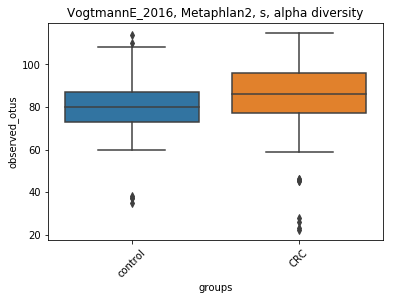

In [70]:
plt = sns.boxplot(x="groups", y="observed_otus", data=div_table)
plt.set_xticklabels(plt.get_xticklabels(),rotation=45)
plt.set_title("VogtmannE_2016, Metaphlan2, s, alpha diversity")

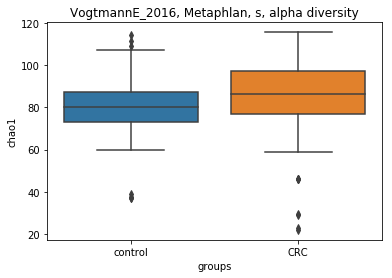

In [146]:
_ = calc_div("VogtmannE_2016", "Metaphlan", "s", "chao1")

In [144]:
def calc_div (dataset_name, method, rank, div_measure):
    # Find path to dataset file
    if method == "Kraken":
        table_files = files_kraken
        rank = rank.upper()
    else:
        if method == "Metaphlan":
            table_files = files_metaphlan
            rank = rank.lower()
        else:
            print("Wrong method! Method should be 'Kraken' or 'Metaphlan'")
            raise
    
    table, groups = get_table_and_grouping(dataset_name, table_files, rank = rank, counts = True)
    
    div_table = pd.DataFrame(alpha_diversity(div_measure, np.array(table), np.array(table.index)))
    div_table[div_measure] = div_table[0]
    div_table = div_table.drop(columns=0)
    div_table["groups"] = groups
    

    if "adenoma" in list(groups.drop_duplicates()):
        group_order = ["control", "CRC", "adenoma"]
    else:
        group_order = ["control", "CRC"]
    
    plt = sns.boxplot(x="groups", y=div_measure, data=div_table, order=group_order)
    #plt.set_xticklabels(plt.get_xticklabels(),rotation=45)
    plt.set_title(", ".join([dataset_name, method, rank, "alpha diversity"]))
    plt.get_figure().savefig("_".join([dataset_name, method, rank, div_measure, "alphadiversity.png"]))
    return div_table

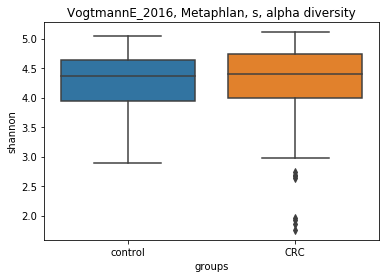

In [225]:
_ = calc_div("VogtmannE_2016", "Metaphlan", "s", "shannon")

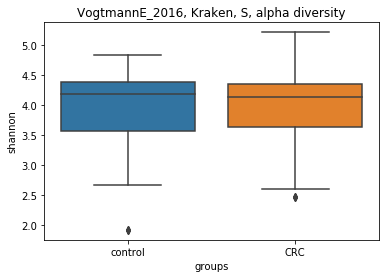

In [148]:
_ = calc_div("VogtmannE_2016", "Kraken", "s", "shannon")

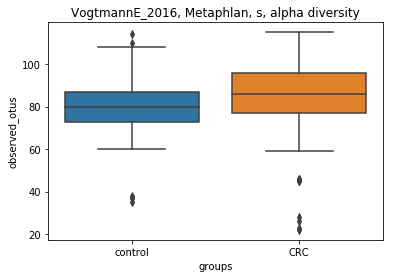

In [145]:
VogtmannE_2016_s = calc_div("VogtmannE_2016", "Metaphlan", "s", "observed_otus")

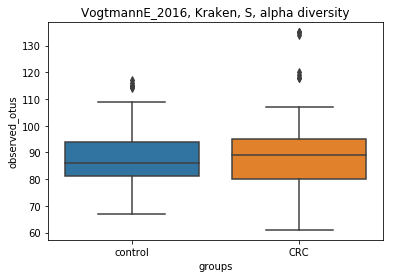

In [147]:
VogtmannE_2016_s_k = calc_div("VogtmannE_2016", "Kraken", "s", "observed_otus")

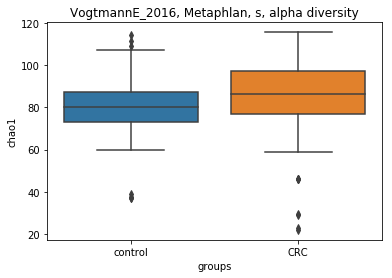

In [149]:
_ = calc_div("VogtmannE_2016", "Metaphlan", "s", "chao1")

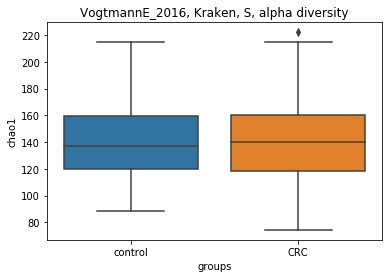

In [150]:
_ = calc_div("VogtmannE_2016", "Kraken", "s", "chao1")

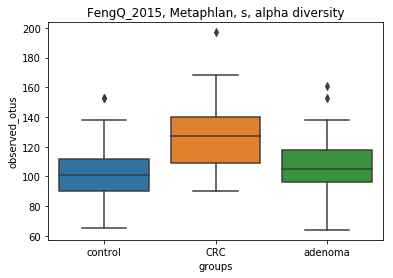

In [224]:
_ = calc_div("FengQ_2015", "Metaphlan", "s", "observed_otus")

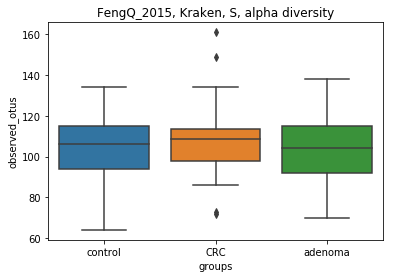

In [151]:
_ = calc_div("FengQ_2015", "Kraken", "s", "observed_otus")

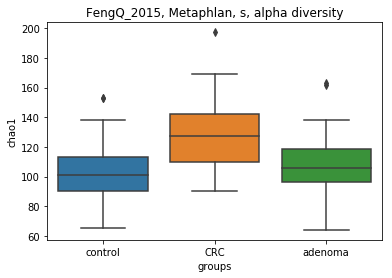

In [223]:
_ = calc_div("FengQ_2015", "Metaphlan", "s", "chao1")

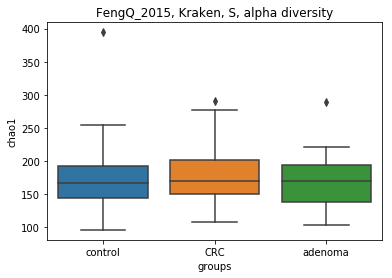

In [152]:
_ = calc_div("FengQ_2015", "Kraken", "s", "chao1")

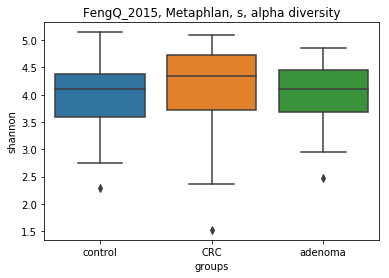

In [153]:
_ = calc_div("FengQ_2015", "Metaphlan", "s", "shannon")

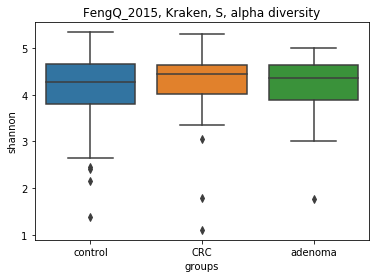

In [154]:
_ = calc_div("FengQ_2015", "Kraken", "s", "shannon")

In [212]:
def calc_beta_div (dataset_name, method, rank, div_measure):
    # Find path to dataset file
    if method == "Kraken":
        table_files = files_kraken
        rank = rank.upper()
    else:
        if method == "Metaphlan":
            table_files = files_metaphlan
            rank = rank.lower()
        else:
            print("Wrong method! Method should be 'Kraken' or 'Metaphlan'")
            raise
    
    table, groups = get_table_and_grouping(dataset_name, table_files, rank = rank, 
                                           counts = True)
    
    div_table = beta_diversity(div_measure, np.array(table), np.array(table.index))
    
    distance_df = pd.DataFrame(div_table.data, div_table.ids, div_table.ids)
    
    linkage = hc.linkage(sp.distance.squareform(distance_df), method='average')
    
    lut = dict(zip(["CRC", "control", "adenoma"], "rbg"))
    row_colors = groups.map(lut)
    g = sns.clustermap(distance_df, row_colors=row_colors, col_linkage=linkage, 
                       row_linkage=linkage)
    g.savefig("_".join([dataset_name, method, rank, div_measure, "betadiversity.png"]))

    return div_table, groups

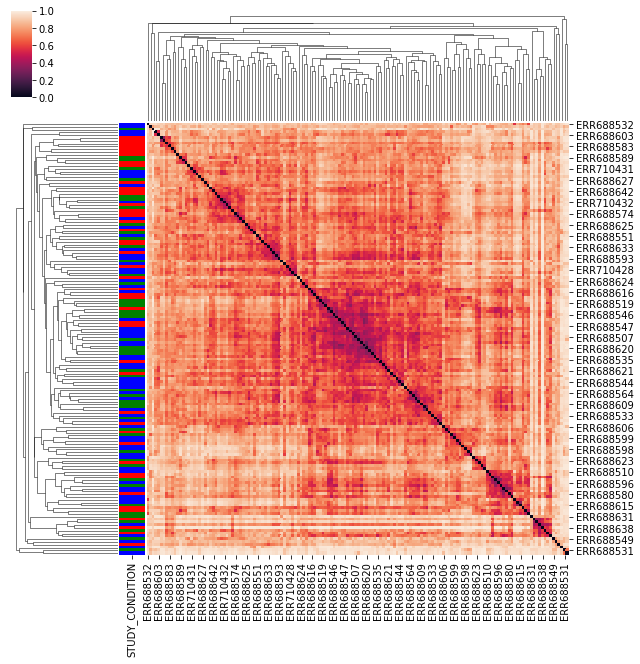

In [213]:
beta_div, groups = calc_beta_div("FengQ_2015", "Metaphlan", "s", "braycurtis")

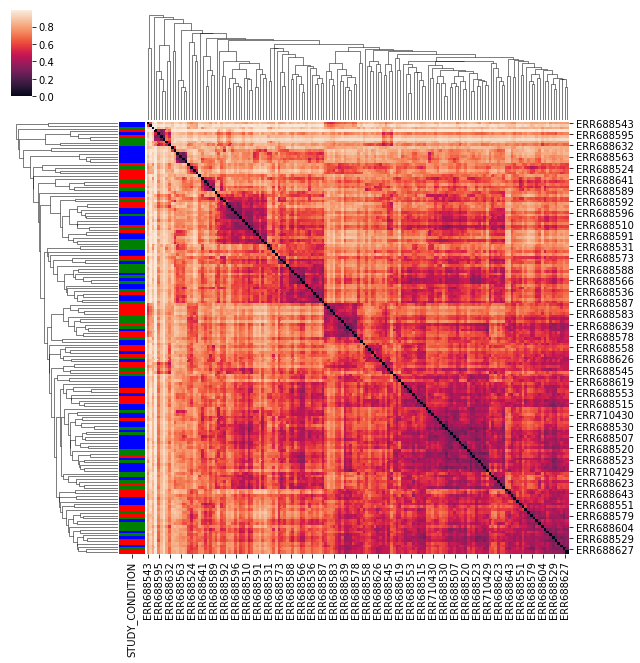

In [221]:
beta_div, groups = calc_beta_div("FengQ_2015", "Kraken", "s", "braycurtis")

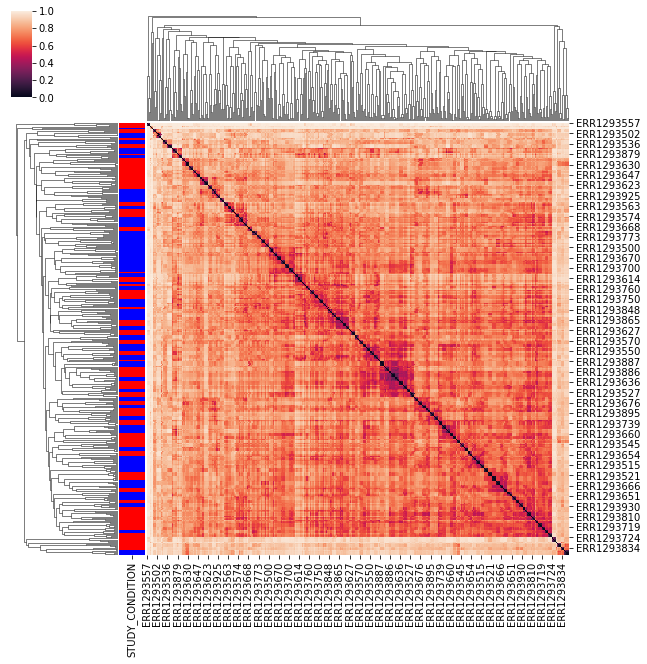

In [214]:
beta_div, groups = calc_beta_div("VogtmannE_2016", "Metaphlan", "s", "braycurtis")

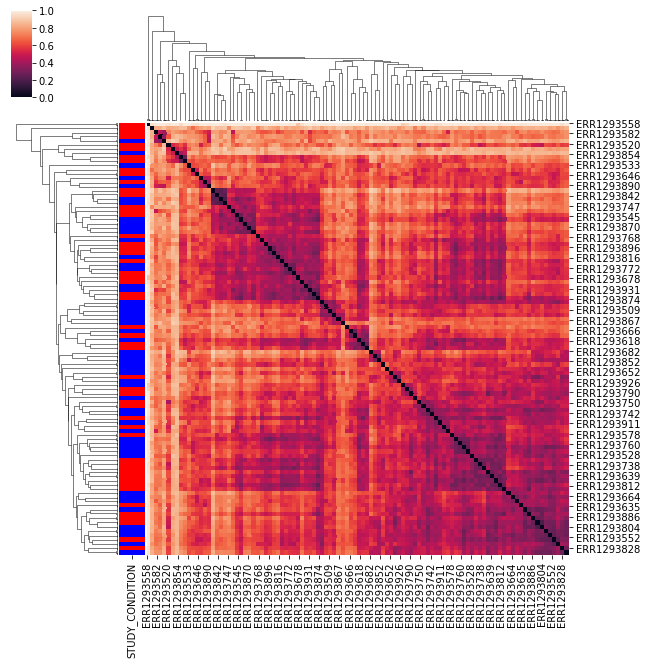

In [222]:
beta_div, groups = calc_beta_div("VogtmannE_2016", "Kraken", "s", "braycurtis")

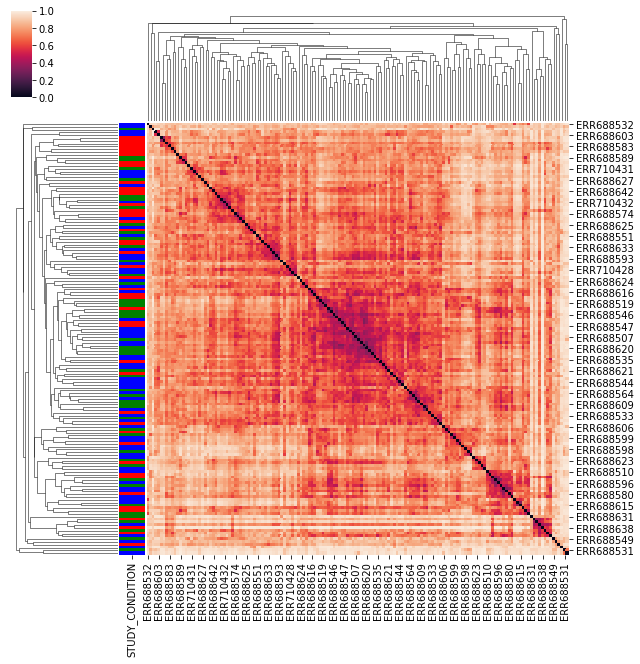

In [199]:
distance_df = pd.DataFrame(beta_div.data, beta_div.ids, beta_div.ids)

linkage = hc.linkage(sp.distance.squareform(distance_df), method='average')

lut = dict(zip(["CRC", "control", "adenoma"], "rbg"))
row_colors = groups.map(lut)

g = sns.clustermap(distance_df, row_colors=row_colors,
                   col_linkage=linkage, row_linkage=linkage)

/gfs/progs/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/gfs/progs/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


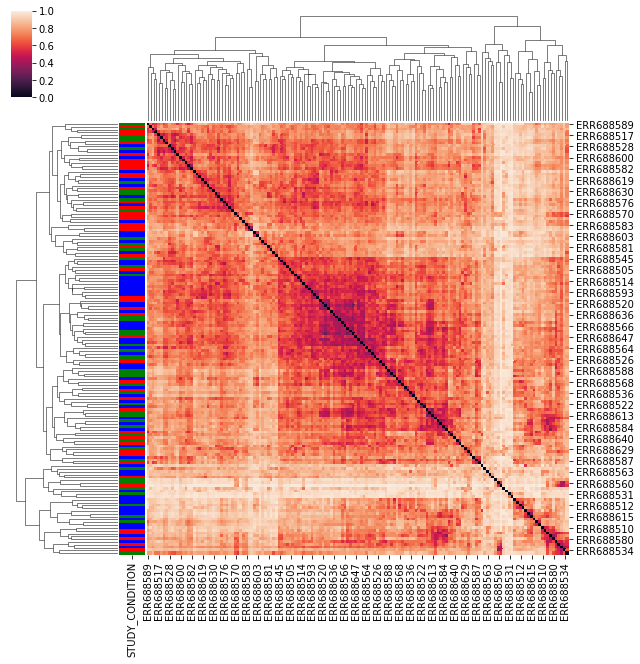

In [198]:
lut = dict(zip(["CRC", "control", "adenoma"], "rbg"))
row_colors = groups.map(lut)
g = sns.clustermap(distance_df, row_colors=row_colors)